# Multiple paths pruning pathfinder
1. Split a Quetzal model
2. Run multiple paths pruning pathfinder with:
    - route breaker
    - mode breaker
3. Combine two pathfinder results
4. Export

In [2]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [3]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

C:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_env\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


SQLalchemy is not installed. No support for SQL output.


In [4]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [5]:
sm = stepmodel.read_zip(training_folder + r'model/base/walk_model.zip'.format(scen=scenario))

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.38it/s]


# ROUTE BREAKER: rail submodel

In [6]:
# add required fields
sm.links['length'] = sm.links.length

Create a stepmodel named `rail` based on `sm` with only rail-based modes.

In [8]:
rail.step_pt_pathfinder(
    broken_routes=True,
    broken_modes=False,
    route_column='route_short_name',
    mode_column='route_type',
    speedup=True
)

path_analysis: 100%|███████████████████████████████████████████████████████████| 29115/29115 [00:02<00:00, 9712.10it/s]


In [9]:
rail.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

route_breaker    17015
best_path        12100
Name: pathfinder_session, dtype: int64

# MODE BREAKER

In [11]:
sm.links.drop(['index'], axis=1,inplace=True, errors='ignore')

sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True,
    route_column='route_short_name'
)

path_analysis: 100%|███████████████████████████████████████████████████████████| 62308/62308 [00:07<00:00, 8394.67it/s]


# CONCATENATION

Identify attributes that needs to be concatenated to keep the results of both pathfinders.  
Create a `both` stepmodel based on `sm` and with all pathfinder results.

In [14]:
both.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

mode_breaker     62308
route_breaker    12488
Name: pathfinder_session, dtype: int64

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:00<00:00,  7.59s/it]


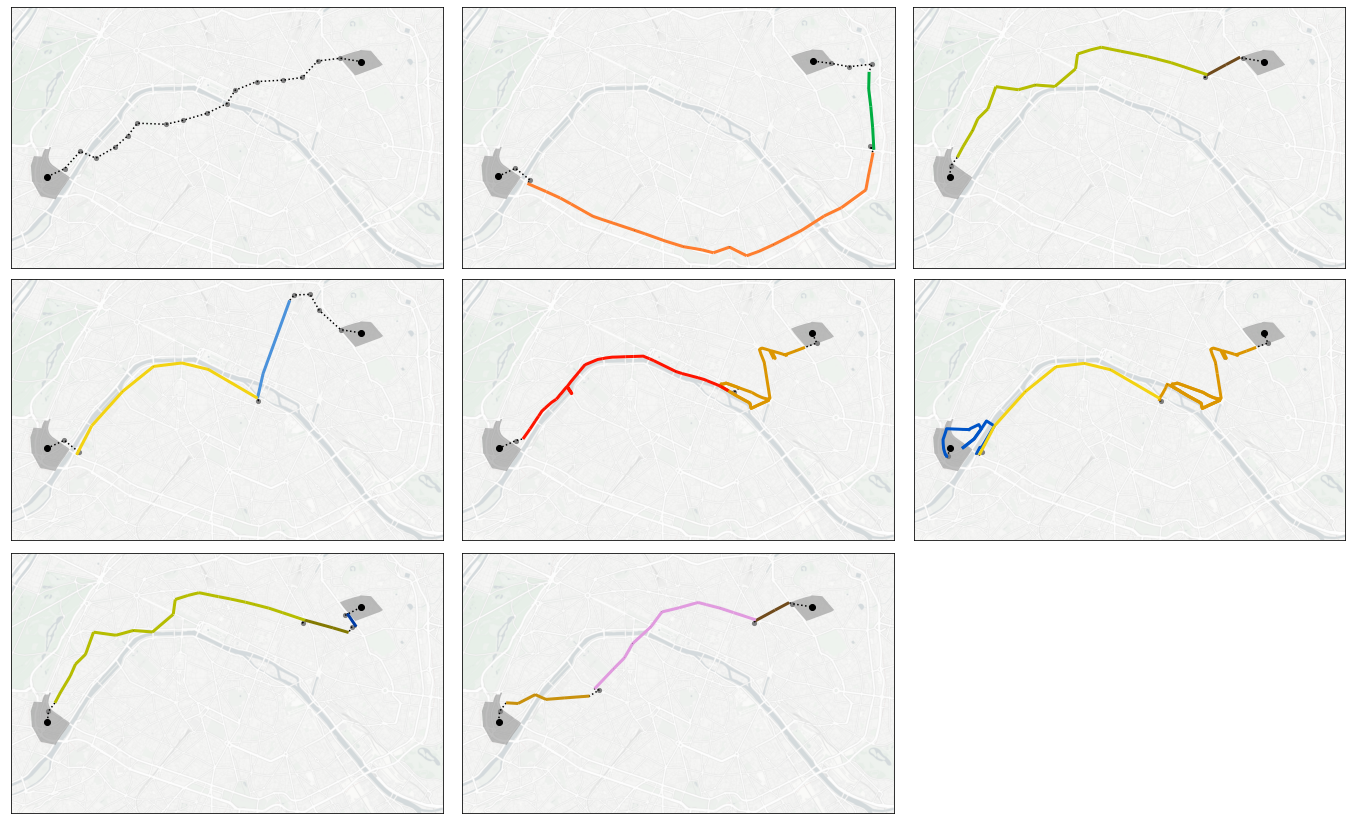

In [17]:
both.links['color'] = '#' + both.links['route_color']
origin, destination='zone_74',  'zone_105'
rows = 3
both_3857 = both.change_epsg(epsg=3857, coordinates_unit='meter')
fig, axes = both_3857.plot_separated_paths(
    origin, destination, rows=rows, figsize=[20, 20],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', 
)

Save `both` stepmodel as zip file in the folder `'model/{scenario}/pruning_pt_pathfinder.zip'` , with `{scenario}` being the name of the given `scenario` variable.

# END